https://colab.research.google.com/drive/1DhkqsnOklP8WsJ9X-Mk1VmfzWw4Sp2uC?usp=sharing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Обработка и визуализация данных

Загрузим тренировочную выборку.

In [2]:
df_train = pd.read_csv("train.csv")
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Удалим столбец Id, т.к. он ни на что не влияет.

In [3]:
df_train = df_train.drop('Id',1)

Посмотрим общую информацию о датафрейме.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Посмотрим описательную статистику по интересующему нас столбцу

In [ ]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Мы видим, что минимальная цена больше нуля.

## Визуализация данных

Отобразим ключевой признак на гистограмме.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


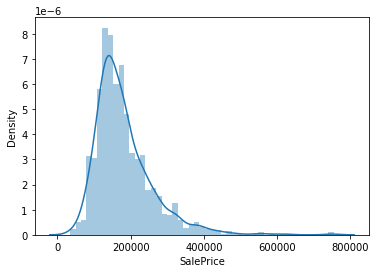

In [ ]:
sns.distplot(df_train['SalePrice'])

Отобразим матрицу корреляции в стиле тепловой карты

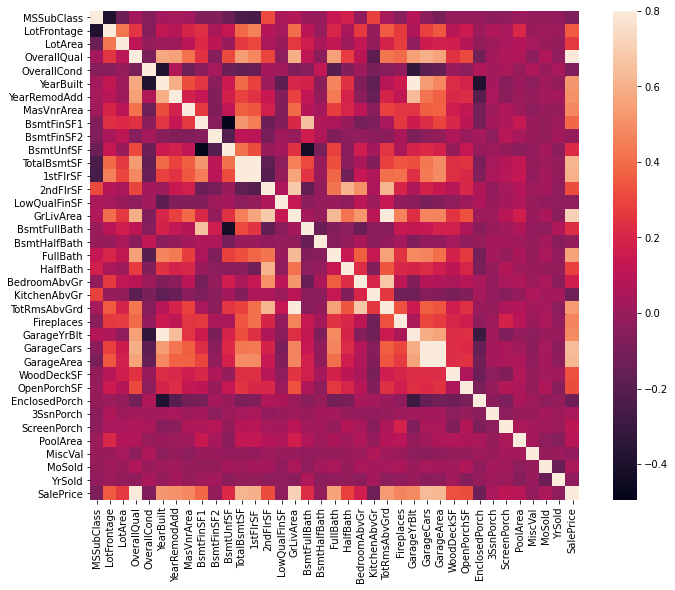

In [ ]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Привлекают внимания двва белых квадрата. Первый относится к переменным TotalBsmtSf и 1stFirSF. Второй к переменным GarageX. Оба случая показывают, насколько значительна корреляция между этими переменными. Эта корреляция настолько сильна, что может указывать на ситуацию мультиколлинеарности. Если мы подумаем об этих переменных, мы можем сделать вывод, что они дают почти одинаковую информацию, поэтому мультиколлинеарность действительно имеет место.

Изобразим матрицу корреляции SalePrice в стиле уменьшенной тепловой карты.

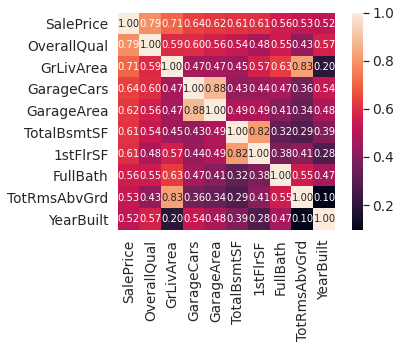

In [ ]:
cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

TotalQual, GrLivArea и TotalBsmtSF сильно коррелируют с SalePrice. 
«GarageCars» и «GarageArea» также являются одними из наиболее сильно коррелированных переменных. Однако, как мы обсуждали в последнем подпункте,
Количество машин, которые помещаются в гараж, зависит от площади гаража. GarageCars и GarageArea практически одинаковые.Следовательно, можно оставить только одну из этих переменных (мы можем оставить GarageCars, поскольку ее корреляция с SalePrice выше).
TotalBsmtSF и 1stFloor тоже кажутся похожими. Мы можем оставить «TotalBsmtSF».

Построим диаграммы разброса между SalePrice и коррелированными переменными

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


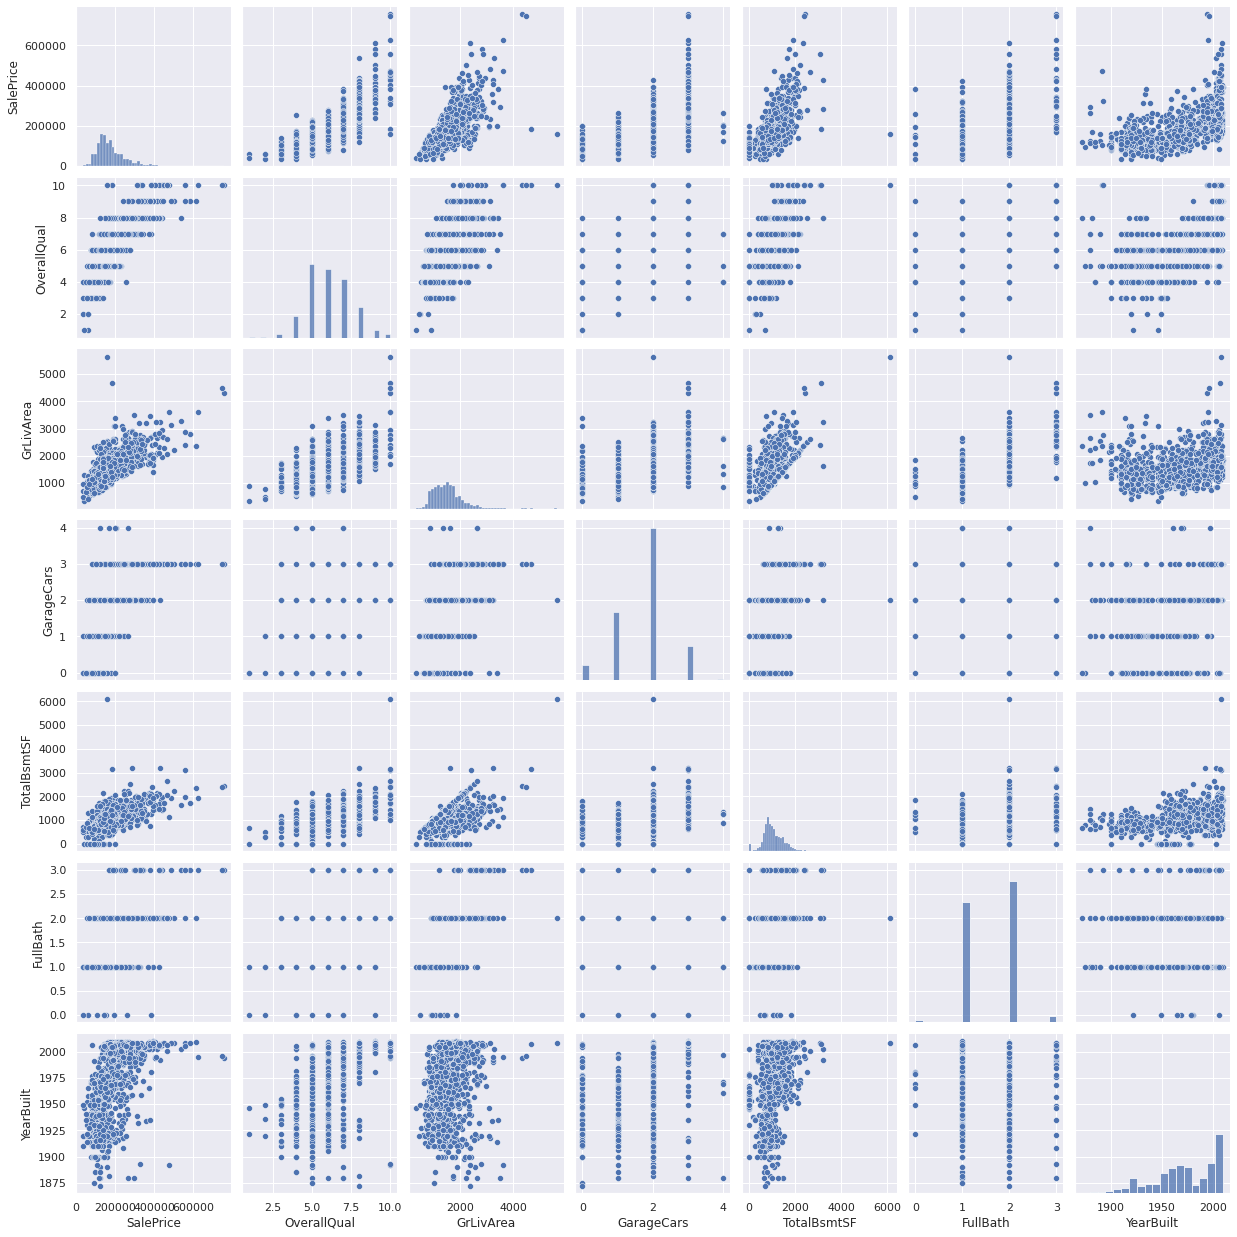

In [ ]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

Одна из диаграмм, которая может показаться нам интересной, - это диаграмма между TotalBsmtSF и GrLiveArea. На этом рисунке мы можем видеть, как точки рисуют линию, которая почти действует как граница. Большинство точек остаются ниже этой линии. Площадь подвала может быть равна жилой площади над землей, но не предполагается, что площадь подвала больше жилой площади над землей.


## Обработка пропусков

Отобразим количество недостающих данных, в таблице.

In [5]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


Удалим те признаки в которых процент отсутствующих значений больше 15. Так же удалим переменные GarageX, т.к. наиболее важная информация содержится в GarageCars. Та же логика применима к переменным BsmtX. Т.к. в признаке Electrical отсутствует только 1 значение удалим это наблюдение.

In [6]:
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max()

0

In [7]:
df_train =df_train.reset_index(drop=True)

Отделим от данных целевой признак 

In [8]:
y_train = df_train['SalePrice']
X_train = df_train.drop('SalePrice', 1)

Загрузим данные по которым нам нужно предсказать цену дома.

In [9]:
df_test = pd.read_csv("test.csv")
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

Обработаем эти данные от пропусков, таким же образом.

In [11]:
total_test = df_test.isnull().sum().sort_values(ascending=False)
percent_test = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data_test = pd.concat([total_test, percent_test], axis=1, keys=['Total', 'Percent'])
missing_data_test.head(20)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageQual,78,0.053461
GarageYrBlt,78,0.053461
GarageFinish,78,0.053461


In [12]:
df_test = df_test.drop((missing_data_test[missing_data_test['Total'] > 4]).index,1)
df_test.isnull().sum().max()

4

Заполним строчки с пропусками самыми популярными значениями по каждой категории.

In [13]:
df_test['MSZoning'] = df_test['MSZoning'].fillna('RL')
df_test['BsmtHalfBath'] = df_test['BsmtHalfBath'].fillna(0.0)
df_test['Utilities'] = df_test['Utilities'].fillna('AllPub')
df_test['BsmtFullBath'] = df_test['BsmtFullBath'].fillna(0.0)
df_test['Functional'] = df_test['Functional'].fillna('Typ')
df_test['KitchenQual'] = df_test['KitchenQual'].fillna('TA')
df_test['GarageCars'] = df_test['GarageCars'].fillna(2.0)
df_test['GarageArea'] = df_test['GarageArea'].fillna(0.0)
df_test['Exterior1st'] = df_test['Exterior1st'].fillna('VinylSd')
df_test['BsmtFinSF1'] = df_test['BsmtFinSF1'].fillna(0.0)
df_test['Exterior2nd'] = df_test['Exterior2nd'].fillna('VinylSd')
df_test['SaleType'] = df_test['SaleType'].fillna('WD')
df_test['TotalBsmtSF'] = df_test['TotalBsmtSF'].fillna(0.0)
df_test['BsmtUnfSF'] = df_test['BsmtUnfSF'].fillna(0.0)
df_test['BsmtFinSF2'] = df_test['BsmtFinSF2'].fillna(0.0)

In [14]:
df_test =df_test.reset_index(drop=True)

In [15]:
Id_test = df_test['Id']

In [16]:
df_test = df_test.drop('Id',1)

Объеденим тренировочные и тестовые данные для кодирования котегориальных признаков.

In [17]:
X = pd.concat([X_train, df_test])

In [18]:
X = X.reset_index(drop = True)
X.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,706.0,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,2.0,548.0,Y,0,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,978.0,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,2.0,460.0,Y,298,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,486.0,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,2.0,608.0,Y,0,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,216.0,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,3.0,642.0,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,655.0,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,3.0,836.0,Y,192,84,0,0,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,160,RM,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,TA,TA,CBlock,0.0,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,0.0,0.0,Y,0,0,0,0,0,0,0,6,2006,WD,Normal
2914,160,RM,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,TA,TA,CBlock,252.0,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,1.0,286.0,Y,0,24,0,0,0,0,0,4,2006,WD,Abnorml
2915,20,RL,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,TA,TA,CBlock,1224.0,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,2.0,576.0,Y,474,0,0,0,0,0,0,9,2006,WD,Abnorml
2916,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,TA,TA,PConc,337.0,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,0.0,0.0,Y,80,32,0,0,0,0,700,7,2006,WD,Normal


## Кодирование категориальных признаков

Разделим общий набор на категориальные и числовые признаки

In [19]:
category_cols = X.select_dtypes(['object']).columns
numerical_cols = X.select_dtypes(['float64', 'int64']).columns

In [20]:
X_cat = X[category_cols]
X_num = X[numerical_cols]

Перекодируем категориальные признаки.

In [21]:
encoder = DV(sparse = False)
cat_encoded = encoder.fit_transform(X_cat.T.to_dict().values())
print(cat_encoded)

[[1. 0. 0. ... 1. 1. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 ...
 [1. 0. 0. ... 1. 1. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 [1. 0. 0. ... 1. 1. 0.]]


Объединим перекодированные категориальные признаки и числовые.

In [22]:
X_encoded = pd.concat([pd.DataFrame(cat_encoded),X_num],axis = 1)

In [23]:
X_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,180,181,182,183,184,185,186,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,60,8450,7,5,2003,2003,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2.0,548.0,0,61,0,0,0,0,0,2,2008
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,20,9600,6,8,1976,1976,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,2.0,460.0,298,0,0,0,0,0,0,5,2007
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,60,11250,7,5,2001,2002,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2.0,608.0,0,42,0,0,0,0,0,9,2008
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,70,9550,7,5,1915,1970,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,3.0,642.0,0,35,272,0,0,0,0,2,2006
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,60,14260,8,5,2000,2000,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,3.0,836.0,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,160,1936,4,7,1970,1970,0.0,0.0,546.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,5,0,0.0,0.0,0,0,0,0,0,0,0,6,2006
2914,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,160,1894,4,5,1970,1970,252.0,0.0,294.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,6,0,1.0,286.0,0,24,0,0,0,0,0,4,2006
2915,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,20,20000,5,7,1960,1996,1224.0,0.0,0.0,1224.0,1224,0,0,1224,1.0,0.0,1,0,4,1,7,1,2.0,576.0,474,0,0,0,0,0,0,9,2006
2916,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,85,10441,5,5,1992,1992,337.0,0.0,575.0,912.0,970,0,0,970,0.0,1.0,1,0,3,1,6,0,0.0,0.0,80,32,0,0,0,0,700,7,2006


Отделим тренировочную и тестовую выборки

In [24]:
X_encoded_train = X_encoded.iloc[0:1459]
X_encoded_test = X_encoded.iloc[1459:]

# Выбор модели регрессии

Разделим тренировочную выборку на 2 части: тренировочную и тестовую для подбора наилучших модели и гиперпараметров.

In [25]:
(X_train_train, X_train_test, y_train_train, y_train_test) = train_test_split(X_encoded_train, y_train,test_size = 0.2, random_state = 0)

Проверим регрессию дерева решений: осуществляется с помощью sklearn.tree.DecisionTreeRegressor.
Ссылка на документацию: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

## Регрессия дерева решений

Осуществляется с помощью sklearn.tree.DecisionTreeRegressor.

Ссылка на документацию: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html


In [34]:
dtr = DecisionTreeRegressor(random_state=123)
dtr.fit(X_train_train, y_train_train)
y_pred_train_dtr = dtr.predict(X_train_test)
print(r2_score(y_train_test, y_pred_train_dtr))
print(mean_squared_error(y_train_test, y_pred_train_dtr))
print(mean_squared_error(y_train_test, y_pred_train_dtr, squared=False))
print(mean_absolute_error(y_train_test, y_pred_train_dtr))

0.7363385424584968
1602542361.578767
40031.766905531
25637.462328767124


In [35]:
dtr_parameters_grid = {'criterion' : ['mse', 'friedman_mse', 'mae', 'poisson'],
                       'max_depth' : range(1, 11),
                       'min_samples_split' : range(1, 10) 
}

Подберём параметры по сетке с помощью sklearn.model_selection.GridSearchCV.

In [53]:
dtr_grid = GridSearchCV(dtr, dtr_parameters_grid,
                        cv=5, n_jobs=-1, verbose=True)
dtr_grid.fit(X_train_train, y_train_train)
dtr_grid.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1984 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 2478 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  2.9min finished


{'criterion': 'mse',
 'max_depth': 7,
 'min_samples_split': 6,
 'splitter': 'best'}

In [54]:
dtr_with_params = DecisionTreeRegressor(criterion='mae', max_depth=7, min_samples_split=6,random_state=123)
dtr_with_params.fit(X_train_train, y_train_train)
y_pred_train_dtr = dtr_with_params.predict(X_train_test)
print(r2_score(y_train_test, y_pred_train_dtr))
print(mean_squared_error(y_train_test, y_pred_train_dtr))
print(mean_squared_error(y_train_test, y_pred_train_dtr, squared=False))
print(mean_absolute_error(y_train_test, y_pred_train_dtr))

0.7979710705698377
1227937980.375
35041.9460129571
23687.69178082192


Результат хорошо улучшился.

## LASSO регрессия

Попробуем LASSO регрессию.
Осуществляется с помощью sklearn.linear_model.Lasso.

Ссылка на документацию: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [61]:
lasso = Lasso(random_state=123)
lasso.fit(X_train_train, y_train_train)
y_pred_train_lasso = lasso.predict(X_train_test)
print(r2_score(y_train_test, y_pred_train_lasso))
print(mean_squared_error(y_train_test, y_pred_train_lasso))
print(mean_squared_error(y_train_test, y_pred_train_lasso, squared=False))
print(mean_absolute_error(y_train_test, y_pred_train_lasso))

0.8939462850907129
644597706.2012458
25388.928811614835
18237.998777126864


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59236695630.91675, tolerance: 742969215.2119777
  positive)


Попробуем улучшить модель, подбором гиперпараметров.

In [59]:
lasso_parameters_grid = {'alpha' : np.arange(0.01, 1.0, 0.05),
                         'normalize' : [True, False],
                         'max_iter' : [10, 50 ,100, 200, 400, 800, 1000, 1500, 2000],
                         'selection' : ['cyclic', 'random'],
                         'warm_start':[True,False]
                         }

In [60]:
lasso_grid = GridSearchCV(lasso, lasso_parameters_grid, cv = 5, n_jobs=-1, verbose=True)
lasso_grid.fit(X_train_train, y_train_train)
lasso_grid.best_params_

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1786 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2830 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 3974 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 5416 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 7156 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed: 12.1min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301301354224.271, tolerance: 742969215.2119777
  positive)


{'alpha': 0.9600000000000001,
 'max_iter': 10,
 'normalize': True,
 'selection': 'random',
 'warm_start': True}

In [62]:
lasso_with_params = Lasso(alpha = 0.96,max_iter = 10, normalize = True,random_state=123,selection='random', warm_start=True)
lasso_with_params.fit(X_train_train, y_train_train)
y_pred_train_lasso = lasso_with_params.predict(X_train_test)
print(r2_score(y_train_test, y_pred_train_lasso))
print(mean_squared_error(y_train_test, y_pred_train_lasso))
print(mean_squared_error(y_train_test, y_pred_train_lasso, squared=False))
print(mean_absolute_error(y_train_test, y_pred_train_lasso))

0.8967650725277209
627465030.3895751
25049.25209241935
17735.355687456467


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301301354224.2708, tolerance: 742969215.2119777
  positive)


Результат улучшился, но не сильно.

##Гребневая регрессия
Осуществляется с помощью sklearn.linear_model.Ridge.

Ссылка на документацию: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [63]:
ridge = Ridge(random_state=123)
ridge.fit(X_train_train, y_train_train)
y_pred_train_ridge = ridge.predict(X_train_test)
print(r2_score(y_train_test, y_pred_train_ridge))
print(mean_squared_error(y_train_test, y_pred_train_ridge))
print(mean_squared_error(y_train_test, y_pred_train_ridge, squared=False))
print(mean_absolute_error(y_train_test, y_pred_train_ridge))

0.8965407623715667
628828394.3439478
25076.450991796024
18093.322749861236


Попробуем улучшить модель, подобрав гиперпараметры.

In [64]:
ridge_parameters_grid = {'alpha' : np.arange(0.01, 1.0, 0.05),
                         'max_iter' : [10, 50 ,100, 200, 400],
                         'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
                         'fit_intercept' : [True, False]
                         }

In [66]:
ridge_grid = GridSearchCV(ridge, ridge_parameters_grid, cv = 5, n_jobs=-1, verbose=True)
ridge_grid.fit(X_train_train, y_train_train)
ridge_grid.best_params_

Fitting 5 folds for each of 2520 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 454 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 955 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1799 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2783 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 4039 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 5537 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 7191 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 9113 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 11245 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed: 24.6min finished


{'alpha': 0.9600000000000001,
 'fit_intercept': False,
 'max_iter': 10,
 'solver': 'svd'}

In [67]:
ridge_with_params = Ridge(alpha = 0.96, fit_intercept = False, max_iter = 10, solver = 'svd',random_state=123)
ridge_with_params.fit(X_train_train, y_train_train)
y_pred_train_ridge = ridge_with_params.predict(X_train_test)
print(r2_score(y_train_test, y_pred_train_ridge))
print(mean_squared_error(y_train_test, y_pred_train_ridge))
print(mean_squared_error(y_train_test, y_pred_train_ridge, squared=False))
print(mean_absolute_error(y_train_test, y_pred_train_ridge))

0.8966551800905052
628132959.9667584
25062.5808720243
18071.711946088686


Отличия минимальны.

Elastic Net регрессия
Осуществляется с помощью sklearn.linear_model.ElasticNet

Ссылка на документацию: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [68]:
en = ElasticNet(random_state=123)
en.fit(X_train_train, y_train_train)
y_pred_train_en = en.predict(X_train_test)
print(r2_score(y_train_test, y_pred_train_en))
print(mean_squared_error(y_train_test, y_pred_train_en))
print(mean_squared_error(y_train_test, y_pred_train_en, squared=False))
print(mean_absolute_error(y_train_test, y_pred_train_en))

0.857438926944929
866490539.8503863
29436.211370527733
19383.902005161468


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 776439152927.7115, tolerance: 742969215.2119777
  positive)


Подберём и здесь гиперпараметры.

In [71]:
en_parameters_grid = {'alpha' : np.arange(0.01, 1.0, 0.05),
                         'l1_ratio' : np.arange(0.1, 1.0, 0.1),
                         'max_iter' : [10, 50 ,100, 200,400],
                         'fit_intercept' : [True, False],
                         'normalize' : [True, False],
                         'selection' : ['cyclic', 'random'],
                         }

In [72]:
en_grid = GridSearchCV(en, en_parameters_grid, cv = 5, n_jobs=-1, verbose=True)
en_grid.fit(X_train_train, y_train_train)
en_grid.best_params_

Fitting 5 folds for each of 7200 candidates, totalling 36000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1416 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 3416 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6216 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 9816 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 14216 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 19416 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 25416 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 32216 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 36000 out of 36000 | elapsed: 13.8min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 515539126877.91473, tolerance: 4594849705.7277
  positive)


{'alpha': 0.11,
 'fit_intercept': False,
 'l1_ratio': 0.9,
 'max_iter': 100,
 'normalize': True,
 'selection': 'random'}

In [79]:
en_with_params = ElasticNet(alpha = 0.11, fit_intercept = False,normalize = True,l1_ratio=0.9,max_iter=100,random_state= 123,selection='random')
en_with_params.fit(X_train_train, y_train_train)
y_pred_train_en = en_with_params.predict(X_train_test)
print(r2_score(y_train_test, y_pred_train_en))
print(mean_squared_error(y_train_test, y_pred_train_en))
print(mean_squared_error(y_train_test, y_pred_train_en, squared=False))
print(mean_absolute_error(y_train_test, y_pred_train_en))

0.8936968452429231
646113809.1860218
25418.76883694452
17788.08861696445


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 515539126877.91473, tolerance: 4594849705.7277
  positive)


Точность улучшилась, но не превзошла гребневую регрессию

## Формируем файл с ответом для загрузки на keggle

Несмотря на то, что лучшим методом оказалась гребневая регрессия, при прогнозировании ответов и загрузке на keggle, она показала себя очень плохо. Значит тестирование моделей не дало нужного результата. Лучшей моделью оказалась ElasticNet.

In [141]:
final_en = ElasticNet(alpha = 0.11, fit_intercept = False,normalize = True,l1_ratio=0.9,max_iter=100,random_state= 123,selection='random')
final_en.fit(X_encoded_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615654025820.501, tolerance: 5696927460.3338
  positive)


ElasticNet(alpha=0.11, copy_X=True, fit_intercept=False, l1_ratio=0.9,
           max_iter=100, normalize=True, positive=False, precompute=False,
           random_state=123, selection='random', tol=0.0001, warm_start=False)

In [142]:
y_pred_final_en = final_en.predict(X_encoded_test)

In [143]:
y_pred_final_en = pd.DataFrame(y_pred_final_en,columns=['SalePrice'],index = Id_test)

In [145]:
y_pred_final_en

,SalePrice
Id,
1461,109382.664641
1462,159372.260374
1463,176440.225151
1464,194851.554174
1465,215493.764820
...,...
2915,67415.733904
2916,69450.951350
2917,175977.153420


In [140]:
y_pred_final_en.to_csv('predict.csv')